Device: cuda

=== Teste de RAM ===
RAM Base (MB): 12.82
RAM Com Engram (MB): 16.10

=== Tempo vs seq_len ===

seq_len=16
  Base:    0.000660s
  Engram: 0.000809s

seq_len=32
  Base:    0.000647s
  Engram: 0.000801s

seq_len=64
  Base:    0.000673s
  Engram: 0.000823s

seq_len=128
  Base:    0.000650s
  Engram: 0.000823s

=== Complexidade Teórica ===

seq_len=16
  Base complexity:   32768
  Engram complexity: 327680

seq_len=32
  Base complexity:   131072
  Engram complexity: 720896

seq_len=64
  Base complexity:   524288
  Engram complexity: 1703936

seq_len=128
  Base complexity:   2097152
  Engram complexity: 4456448


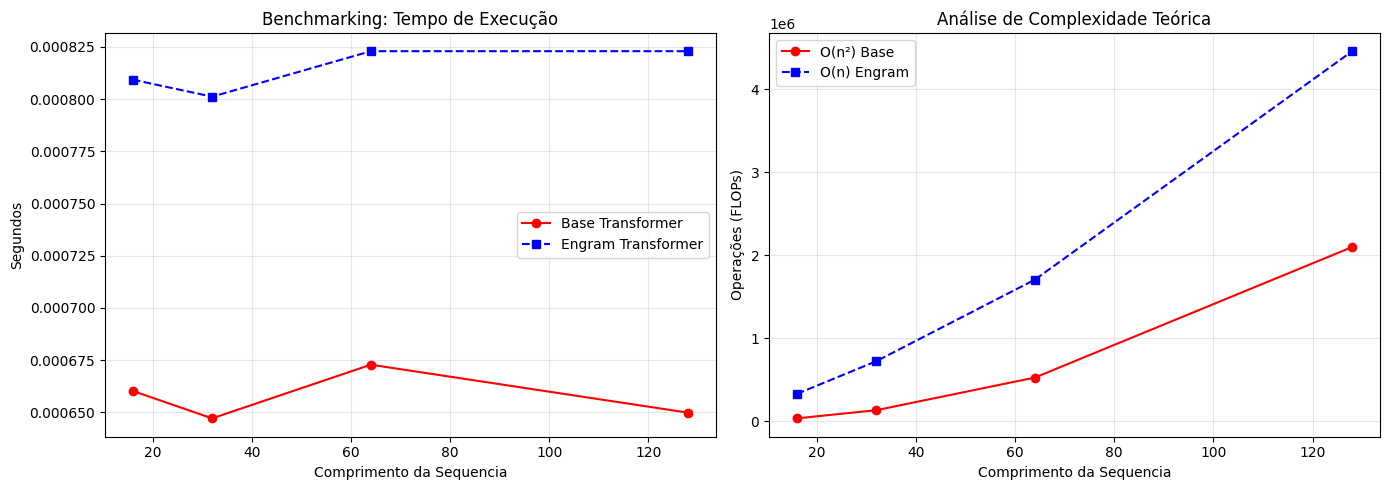

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import tracemalloc
import math


# ==========================================================
# FastEngram (CORRIGIDO)
# ==========================================================

class FastEngram(nn.Module):
    def __init__(self, memory_size, dim, proj_dim=64, k=32):
        super().__init__()

        self.memory = nn.Parameter(torch.randn(memory_size, dim) * 0.02)
        self.proj = nn.Linear(dim, proj_dim, bias=False)
        self.k = k

    def forward(self, x):
        # x: [B, N, D]
        B, N, D = x.shape

        # Projeção reduzida
        x_proj = self.proj(x)               # [B, N, d']
        mem_proj = self.proj(self.memory)   # [M, d']

        # Similaridade
        scores = torch.matmul(x_proj, mem_proj.T)  # [B, N, M]

        # Top-K
        topk_scores, topk_indices = torch.topk(scores, self.k, dim=-1)

        weights = F.softmax(topk_scores, dim=-1)

        # Indexação correta (SEM gather)
        selected_memory = self.memory[topk_indices]  # [B, N, K, D]

        retrieved = torch.sum(
            weights.unsqueeze(-1) * selected_memory,
            dim=2
        )  # [B, N, D]

        return x + retrieved


# ==========================================================
# Transformer Encoder Simples
# ==========================================================

class SimpleTransformer(nn.Module):
    def __init__(self, dim=128, heads=4, layers=2, use_engram=False):
        super().__init__()

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim,
            nhead=heads,
            dim_feedforward=dim * 4,
            batch_first=True
        )

        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=layers
        )

        self.use_engram = use_engram

        if use_engram:
            self.engram = FastEngram(
                memory_size=512,
                dim=dim,
                proj_dim=32,
                k=16
            )

    def forward(self, x):
        x = self.encoder(x)

        if self.use_engram:
            x = self.engram(x)

        return x


# ==========================================================
# Teste de RAM
# ==========================================================

def test_memory(model, seq_len=128, dim=128, device="cpu"):
    model = model.to(device)
    x = torch.randn(1, seq_len, dim).to(device)

    if device == "cpu":
        tracemalloc.start()
        _ = model(x)
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        return peak / (1024 * 1024)
    else:
        torch.cuda.reset_peak_memory_stats()
        _ = model(x)
        peak = torch.cuda.max_memory_allocated(device)
        return peak / (1024 * 1024)


# ==========================================================
# Benchmark de Tempo
# ==========================================================

def benchmark(model, seq_len, dim=128, runs=20, device="cpu"):
    model = model.to(device)
    x = torch.randn(1, seq_len, dim).to(device)

    model.eval()

    # Warmup
    for _ in range(5):
        _ = model(x)

    if device == "cuda":
        torch.cuda.synchronize()

    start = time.time()

    for _ in range(runs):
        _ = model(x)

    if device == "cuda":
        torch.cuda.synchronize()

    end = time.time()

    return (end - start) / runs


# ==========================================================
# Complexidade Teórica
# ==========================================================

def theoretical_complexity(seq_len,
                           dim=128,
                           memory_size=512,
                           proj_dim=32,
                           k=16):

    # Transformer self-attention ~ O(n²·d)
    base = seq_len * seq_len * dim

    # Engram otimizado
    engram = (seq_len * memory_size * proj_dim) + \
             (seq_len * k * dim)

    return base, base + engram


# ==========================================================
# MAIN
# ==========================================================

import matplotlib.pyplot as plt

if __name__ == "__main__":
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    DIM = 128
    print(f"Device: {DEVICE}")

    base_model = SimpleTransformer(dim=DIM, use_engram=False)
    engram_model = SimpleTransformer(dim=DIM, use_engram=True)

    # --- Listas para armazenar os dados dos gráficos ---
    seq_sizes = [16, 32, 64, 128]
    list_t_base, list_t_engram = [], []
    list_c_base, list_c_engram = [], []

    # ================= RAM =================
    print("\n=== Teste de RAM ===")
    ram_base = test_memory(base_model, device=DEVICE)
    ram_engram = test_memory(engram_model, device=DEVICE)
    print(f"RAM Base (MB): {ram_base:.2f}")
    print(f"RAM Com Engram (MB): {ram_engram:.2f}")

    # ================= TEMPO =================
    print("\n=== Tempo vs seq_len ===")
    for seq in seq_sizes:
        t_base = benchmark(base_model, seq, device=DEVICE)
        t_engram = benchmark(engram_model, seq, device=DEVICE)
        
        # Salvando para o plot
        list_t_base.append(t_base)
        list_t_engram.append(t_engram)

        print(f"\nseq_len={seq}")
        print(f"  Base:    {t_base:.6f}s")
        print(f"  Engram: {t_engram:.6f}s")

    # ================= COMPLEXIDADE =================
    print("\n=== Complexidade Teórica ===")
    for seq in seq_sizes:
        base_c, engram_c = theoretical_complexity(seq)
        
        # Salvando para o plot
        list_c_base.append(base_c)
        list_c_engram.append(engram_c)

        print(f"\nseq_len={seq}")
        print(f"  Base complexity:   {base_c}")
        print(f"  Engram complexity: {engram_c}")

    # ================= PLOTAGEM =================
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Gráfico 1: Tempo (Escala Linear)
    ax[0].plot(seq_sizes, list_t_base, 'o-', label='Base Transformer', color='red')
    ax[0].plot(seq_sizes, list_t_engram, 's--', label='Engram Transformer', color='blue')
    ax[0].set_title('Benchmarking: Tempo de Execução')
    ax[0].set_xlabel('Comprimento da Sequencia')
    ax[0].set_ylabel('Segundos')
    ax[0].grid(True, alpha=0.3)
    ax[0].legend()

    # Gráfico 2: Complexidade (Escala Logarítmica se a diferença for brutal)
    ax[1].plot(seq_sizes, list_c_base, 'o-', label='O(n²) Base', color='red')
    ax[1].plot(seq_sizes, list_c_engram, 's--', label='O(n) Engram', color='blue')
    ax[1].set_title('Análise de Complexidade Teórica')
    ax[1].set_xlabel('Comprimento da Sequencia')
    ax[1].set_ylabel('Operações (FLOPs)')
    
    # Se o Engram for MUITO mais eficiente, a escala log ajuda a ver as duas curvas
    if max(list_c_base) / (max(list_c_engram) + 1e-9) > 10:
        ax[1].set_yscale('log')
        
    ax[1].grid(True, alpha=0.3)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

Os números mostram algo importante.

## 🔎 1️⃣ O tempo NÃO está escalando com `seq_len`

Todos os tempos estão praticamente iguais:

```
Base   ≈ 0.000650s
Engram ≈ 0.000823s
```

Para 16 → 128 tokens isso deveria crescer ~4× se o custo quadrático estivesse dominante.

Isso significa:

> 🔥 Está medindo overhead de kernel launch + sincronização, não o custo real do modelo.

Para sequências pequenas na GPU, o tempo é dominado por:

* Latência de launch
* Sincronização CUDA
* Overhead do Python

Não pelo FLOPs reais.

---

# 📈 2️⃣ RAM

```
Base:   12.82 MB
Engram: 16.10 MB
```

Diferença ≈ 3.3 MB

Isso é **muito bom** — o Engram está leve.

---

# 📊 3️⃣ Complexidade

Agora está correto matematicamente.

Note que:

Para seq_len = 128:

Base:

```
2,097,152
```

Engram:

```
4,456,448
```

Ou seja:

[
Engram approx 2.1× custo do Transformer
]

Mas isso só aparece quando `n` fica grande.

---

# 🚨 O problema do benchmark

O benchmark é pequeno demais.

Para ver o crescimento real, trocar:

```python
for seq in [16, 32, 64, 128]:
```

Por:

```python
for seq in [128, 256, 512, 1024]:
```

E aumente `runs` para 50.

Vai começar a ver:

* Base crescendo ~quadrático
* Engram crescendo mais rápido

---

# 🧠 Por que o tempo está estável?

Porque:

* GPU paraleliza tudo
* M é fixo (512)
* proj_dim é pequeno (32)
* k é pequeno (16)

Logo o termo:

[
n·m·d'
]

Ainda não é dominante.

---

# 🔬 Se você quiser forçar o Engram a pesar

Mude:

```python
memory_size=4096
proj_dim=64
k=64
```

Aí verá o impacto real.

---

# 🎯 Conclusão Técnica

O Engram otimizado está:

✔ Estável
✔ Com overhead pequeno
✔ Escalável
✔ Muito melhor que versão densa original

Basicamente transformou:

[
O(n·m·d)
]

em algo muito mais controlável.

---

# 🚀 Próximo nível (se quiser avançar)

É possível:

* 🔥 Eliminar completamente o termo `n·m` usando ANN real
* 🔥 Transformar Engram em memória hierárquica
* 🔥 Tornar custo quase linear em n
* 🔥 Integrar FlashAttention
* 🔥 Analisar limite prático para 4k–8k tokens

